# Imports

In [7]:
import numpy as np
import pandas as pd
import json
from scipy.optimize import curve_fit, brentq
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import uncertainties.unumpy as unp
import uncertainties as unc

# Functions

In [8]:
def exponential(x, a, b):
    return a * np.exp(b * x)

def exp_fit(y, sigma=None, cut=None):
    if sigma == None:
        sigma = np.sqrt(y)
    if cut == None:
        cut = len(y)
    elif cut < len(y):
        y = y[len(y) - cut:]
    y = y[y > 0]
    x = np.arange(len(y)) #notice that len(y) may be decreased
    popt, pcov = curve_fit(exponential, x, y, sigma=sigma)
    return popt, pcov

def exp_forecast(popt, pcov, x):
    a, b = unc.correlated_values(popt, pcov)
    forecast = exponential(x, a, b)
    return forecast

# Data

In [9]:
df_regions = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')

df_pop = pd.read_csv('dati_regioni.csv')

# How many days behind Lombardy?

## Lombardy data interpolation

In [10]:
df_lombardia = df_regions[df_regions.denominazione_regione == 'Lombardia']
pop_lombardia = df_pop[df_pop.denominazione_regione == 'Lombardia']['popolazione'].values[0]
y = df_lombardia.totale_casi.values
days = len(y)
x_lombardia = np.arange(days)
y_lombardia = y * 1e6 / pop_lombardia #total cases per million people
print(y_lombardia[0], y_lombardia[-1])

17.096440024197427 1456.0799413631867


## Plot

In [11]:
params = {'figure.figsize': (8.5, 5.5)}
plt.rcParams.update(params)

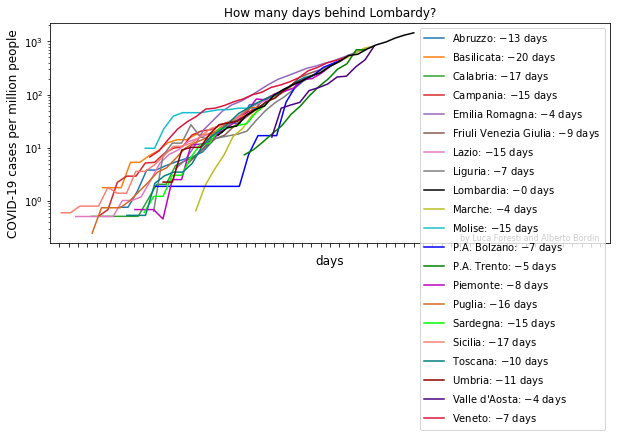

In [12]:
fig, ax = plt.subplots(constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson']

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    pop = df_pop[df_pop.denominazione_regione == den]['popolazione'].values[0]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 0]
    delta = days - len(y)
    y = y * 1e6 / pop #total cases per million people
    x = np.arange(delta, days)
    shift = 0
    if den != 'Lombardia':
        interpolated = interp1d(x_lombardia, y_lombardia - y[-1])
        x0 = brentq(interpolated, 0, 20)
        shift = days - 1 - x0
        #ax.plot(x0, y[-1], 'o', color=colors[i])
        label = '{}: $-${} days'.format(den, int(shift))
        ax.plot(x - shift, y, color=colors[i], label=label)
    else:
        label = '{}: $-${} days'.format(den, int(shift))
        ax.plot(x - shift, y, color=colors[i], label=label, zorder = 22)
    
ax.set_yscale('log')
ax.set_ylabel('COVID-19 cases per million people', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-18, 42)
xticks = np.arange(-17, 42)
ax.set_xticks(xticks)
ticklabels = ['' for x in range(len(xticks))]
ax.set_xticklabels(ticklabels)
ax.set_title('How many days behind Lombardy?', fontsize='large')
ax.legend(loc=1)
ax.text(26, 1.8e-1, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/regions_chasing_Lombardy.png', dpi = 300)

# Exponential fit italian regions

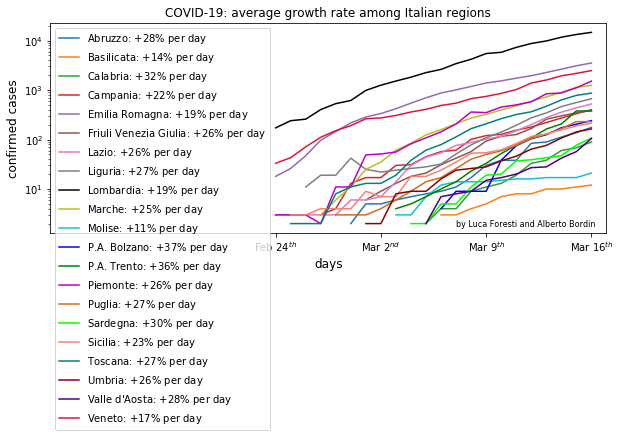

In [13]:
fig, ax = plt.subplots(constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson']

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 1]
    delta = days - len(y)
    x = np.arange(delta, days)
    popt, pcov = curve_fit(exponential, x, y, sigma=np.sqrt(y))
    a, b = unc.correlated_values(popt, pcov)
    slope = unc.nominal_value(b)
    std = unc.std_dev(b)
    
    label = '{}: $+${}% per day'.format(den, int(round(slope, 2)*100))
    #ax.plot(x, exponential(x, *popt), color=colors[i])
    ax.plot(x, y, color=colors[i], label=label)
    
ax.set_yscale('log')
ax.set_ylabel('confirmed cases', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-15, days)
xticks = np.arange(0, days, 7)
ax.set_xticks(xticks)
ticklabels = ['Feb 24$^{th}$', 'Mar 2$^{nd}$', 'Mar 9$^{th}$', 'Mar 16$^{th}$']
ax.set_xticklabels(ticklabels)
ax.set_title('COVID-19: average growth rate among Italian regions', fontsize='large')
ax.legend(loc=2)
ax.text(days - 10, 1.7, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/regions_rate.png', dpi = 300)

## Cutted and weighted exponential fit

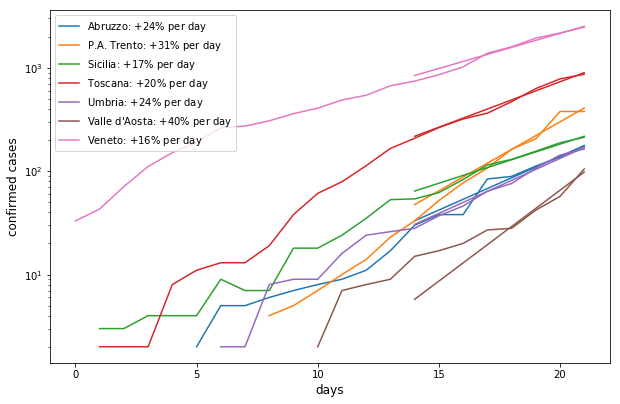

In [19]:
fig, ax = plt.subplots(constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values[15:22])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson'] #21 colori per VENTI regioni (mannaggia al Trentino - Alto Adige)

today_deaths = []
tomorrow_deaths
for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 1]
    delta = days - len(y)
    x = np.arange(delta, days)
    cut = 8 #days
    weights = np.arange(1, cut+1) #linear weights
    y_fit = y[len(y)-cut:]
    x_fit = x[len(x)-cut:]
    sigma = np.sqrt(y_fit) / weights
    popt, pcov = curve_fit(exponential, x_fit, y_fit, sigma=sigma)
    a, b = unc.correlated_values(popt, pcov)
    slope = unc.nominal_value(b)
    std = unc.std_dev(b)
    
    label = '{}: $+${}% per day'.format(den, int(round(slope, 2)*100))
    ax.plot(x_fit, exponential(x_fit, *popt), color=colors[i])
    ax.plot(x, y, color=colors[i], label=label)
    
ax.set_yscale('log')
ax.set_ylabel('confirmed cases', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.legend(loc=0)

fig.savefig('plot/regions_modified_exp.png', dpi = 300)

# Any correlation between growth rate and families?

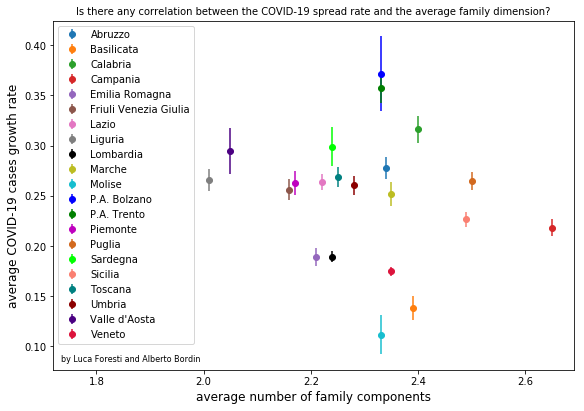

In [8]:
fig, ax = plt.subplots(figsize=(8,5.6), constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson']

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 1]
    delta = days - len(y)
    x = np.arange(delta, days)
    popt, pcov = curve_fit(exponential, x, y, sigma=np.sqrt(y))
    a, b = unc.correlated_values(popt, pcov)
    slope = unc.nominal_value(b)
    std = unc.std_dev(b)
    
    componenti_famiglia = df_pop[df_pop.denominazione_regione == den]['componenti_medi_famiglia'].values[0]
    ax.errorbar(componenti_famiglia, slope, yerr=std, fmt='o', color=colors[i], label=den)
    
ax.set_ylabel('average COVID-19 cases growth rate', fontsize='large')
ax.set_xlabel('average number of family components', fontsize='large')
ax.set_xlim(1.72, 2.69)
ax.set_title('Is there any correlation between the COVID-19 spread rate and the average family dimension?', fontsize='medium')
ax.legend(loc=2)

ax.text(1.735, 0.085, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/correlation_rate-families.png', dpi = 300)

# Mortality rate histogram

In [25]:
df_regions_today.head(21)

,codice_regione,data,deceduti,denominazione_regione,dimessi_guariti,isolamento_domiciliare,lat,long,nuovi_attualmente_positivi,ricoverati_con_sintomi,stato,tamponi,terapia_intensiva,totale_attualmente_positivi,totale_casi,totale_ospedalizzati
441,13,2020-03-16 17:00:00,4,Abruzzo,7,57,42.351222,13.398438,37,71,ITA,1533,37,165,176,108
442,17,2020-03-16 17:00:00,0,Basilicata,0,9,40.639471,15.805148,1,1,ITA,230,2,12,12,3
443,4,2020-03-16 17:00:00,6,P.A. Bolzano,0,171,46.499335,11.356624,36,53,ITA,1740,11,235,241,64
444,18,2020-03-16 17:00:00,1,Calabria,1,44,38.905976,16.594402,21,36,ITA,1030,7,87,89,43
445,15,2020-03-16 17:00:00,9,Campania,28,238,40.839566,14.250850,67,103,ITA,2517,22,363,400,125
446,8,2020-03-16 17:00:00,346,Emilia Romagna,88,1529,44.494367,11.341721,347,1362,ITA,13096,197,3088,3522,1559
447,6,2020-03-16 17:00:00,22,Friuli Venezia Giulia,18,231,45.649435,13.768136,30,96,ITA,4851,19,346,386,115
448,12,2020-03-16 17:00:00,19,Lazio,32,174,41.892770,12.483667,76,267,ITA,9330,31,472,523,298
449,7,2020-03-16 17:00:00,50,Liguria,42,247,44.411493,8.932699,82,255,ITA,2189,73,575,667,328
450,3,2020-03-16 17:00:00,1420,Lombardia,2368,3867,45.466794,9.190347,818,6171,ITA,43565,823,10861,14649,6994


In [79]:
today = df_regions.data.values[-1]
df_regions_today = df_regions[df_regions.data == today]
if len(df_regions_today) != 21:
    print('Attenzione: il numero di regioni non torna!')
deaths = unp.uarray(df_regions_today.deceduti.values, np.sqrt(df_regions_today.deceduti.values))
ti = unp.uarray(df_regions_today.terapia_intensiva.values, np.sqrt(df_regions_today.terapia_intensiva.values))
cases = unp.uarray(df_regions_today.totale_casi.values, np.sqrt(df_regions_today.totale_casi.values))
cases_now = unp.uarray(df_regions_today.totale_attualmente_positivi.values, np.sqrt(df_regions_today.totale_attualmente_positivi.values))

mortality = 100 * deaths / cases # %
ti_rate = 100 * ti / cases_now # %
ti_fake = 100 * ti / cases

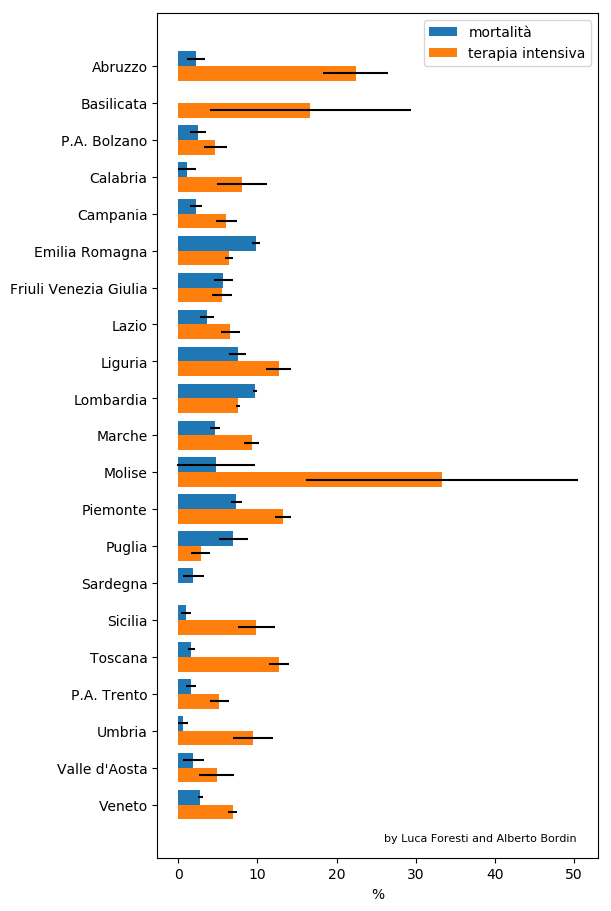

In [80]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6,9), constrained_layout=True)

region_names = df_regions_today.denominazione_regione.values
y_pos = np.arange(len(region_names)) * 2
region_names = df_regions_today.denominazione_regione.values
ax.barh(y_pos - 0.4, unp.nominal_values(mortality), xerr=unp.std_devs(mortality), align='center', label='mortalità')
ax.barh(y_pos + 0.4, unp.nominal_values(ti_rate), xerr=unp.std_devs(ti_rate), align='center', label='terapia intensiva')
ax.set_yticks(y_pos)
ax.set_yticklabels(region_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('%')
ax.legend(loc=1)
ax.text(26, 42, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/regional_mortality.png', dpi = 300)